In [28]:
%matplotlib inline

# Train an RBM to approximate a quantum state
With RBM as a state ansatz, we need to train its parameters in order to make it close to the ground state wave function of a hamiltonian.

Notice that the cost function now is energy rather than a known dataset, we use Markov chain Monte Carlo (MCMC) method to extract the energy expectation value and gradient.

In [10]:
from __future__ import division
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pdb

from utils import binning_statistics
from rbm_tf_cd import load_demo_rbm

A model is a problem definiton, it contains state ansatz, hamiltonian, optimizer and computation graphs for wave function and gradient. Training a model using gradients requires expectation values for at least three operators, $H$, $\frac{\partial}{\partial \Theta}$ and $H\frac{\partial}{\partial \Theta}$.

In [29]:
def train(model, max_iter=2000):
    '''train a model.'''
    E_list, E_err_list = [], []
    for i in range(max_iter):
        E_mean, grad_mean, Egrad_mean, E_err = vmc_measure(model, initial_config=np.array([-1,1]*(model.nsite//2)), num_sample=1000)
        print('Step %d, energy = %s'%(i, E_mean))
        model.update_vars(E_mean, grad_mean, Egrad_mean)
        E_list.append(E_mean)
        E_err_list.append(E_err)
        plt.cla()
        plt.errorbar(np.arange(1,i+2), E_list, yerr=E_err_list)
        plt.show()
        plt.pause(0.01)
    return E_list, E_err_list

The above required expectation values can be approximated by emsemble average of following operators over generated samples in VMC run, $\langle E_{\rm loc}\rangle$, $\langle\Delta_{\rm loc}\rangle$ and $\langle E_{\rm loc}\Delta_{\rm loc}\rangle$, with $E_{\rm loc}=\frac{\langle\psi|H|\sigma\rangle}{\langle\sigma|\psi\rangle}$ and $\Delta_{\rm loc}=\frac{\partial\log\langle\sigma|\psi\rangle}{\partial \Theta}$.

VMC requires a model with following property
* can propose a new configuration, given old configuration.
* can give the wave function amplitude on a spin configuration $\langle\sigma|\psi\rangle$.
* given configuration, being able to provide local quantities $E_{\rm loc}$ and $\Delta_{\rm loc}$.

As a result, VMC measurements give us desired expectation values and and error estimation for energy.

In [12]:
def vmc_measure(model, initial_config, num_bath=200, num_sample=1000, num_bin=50, measure_step=5):
    '''
    Measure an operator.

    Args:
        model (Model): model definition.
        num_sample (int): number of samples.

    Return:
        number,
    '''
    n_accepted = 0
    print_step = num_sample*measure_step/5

    E_locs, grad_locs = [], []
    config = initial_config
    wf = model.get_wf(config)

    for i in range(num_bath + num_sample*measure_step):
        # generate new config and calculate probability ratio
        config_proposed = model.propose_config(config)
        wf_proposed = model.get_wf(config_proposed)
        prob_ratio = np.abs(wf_proposed/wf).item()**2

        # accept/reject move by one-line metropolis algorithm
        if np.random.random() < prob_ratio:
            config = config_proposed
            wf = wf_proposed
            n_accepted += 1

        # measurements
        if i >= num_bath and i%measure_step==0:
            # here, I choose a lazy way that re-compute on this config, in order to get its gradients easily.
            E_loc, grad_loc = model.local_measure(config)
            E_locs.append(E_loc)
            grad_locs.append(grad_loc)

        # print status
        if i%print_step == print_step-1:
            print('%-10s Accept rate: %.3f' % (i + 1, n_accepted*1. / print_step))
            n_accepted = 0

    # process samples
    E_locs = np.array(E_locs)
    E_mean, E_err = binning_statistics(E_locs, num_bin=num_bin)

    grad_mean = []
    Egrad_mean = []
    for grad_locs_i in zip(*grad_locs):
        grad_mean.append(np.mean(grad_locs_i, axis=0))
        Egrad_mean.append(np.mean(E_locs*grad_locs_i))
    return E_mean.item(), grad_mean, Egrad_mean, E_err.item()

In [13]:
class Model(object):
    def __init__(self, J, rbm, sess, learning_rate=0.01):
        self.J = J
        self.sess = sess
        self.nsite = rbm.visible_input.get_shape()[1].value
        self.rbm = rbm
        self.learning_rate = learning_rate
        self.optimizer = tf.train.AdamOptimizer(learning_rate)

        # build graphs
        self.wf_graph = rbm.build_graph('v-prob')
        self.var_list=[rbm.weights,rbm.hidden_bias,rbm.visible_bias]
        self.gradients = tf.gradients(xs=self.var_list, ys=tf.log(self.wf_graph))
        sess.run(tf.global_variables_initializer())

    def get_wf(self, config):
        wf = self.sess.run(self.wf_graph, feed_dict={self.rbm.visible_input:config[None,:]})
        return wf

    def local_measure(self, config):
        '''get E_loc, grad_loc.'''
        # {d/dW}_{loc}
        res = self.sess.run([self.wf_graph]+self.gradients, feed_dict={self.rbm.visible_input:config[None,:]})
        wf = res[0]
        grad_locs = res[1:]

        # E_{loc}
        E_loc = heisenberg_loc(self.J, config, self.get_wf, wf)

        return E_loc, grad_locs

    def update_vars(self, E_mean, grad_mean, Egrad_mean):
        g_list = [eg - E_mean*g for eg,g in zip(Egrad_mean, grad_mean)]  # no conjugate here
        # assign new values
        assign_ops = [var.assign(var-self.learning_rate*g) for var,g in zip(self.var_list, g_list)]
        self.sess.run(assign_ops)
        #for var, g in zip(self.var_list, g_list):
        #    assign_op = var.assign(var-self.learning_rate*g)
        #self.optimizer.apply_gradients(zip(g_list, self.var_list))

    def propose_config(self, old_config):
        '''
        flip two positions as suggested spin flips.
        '''
        nsite = len(old_config)
        upmask=old_config==1
        flips=np.random.randint(0,nsite//2,2)
        iflip0=np.where(upmask)[0][flips[0]]
        iflip1=np.where(~upmask)[0][flips[1]]

        config = old_config.copy()
        config[iflip0] = -1
        config[iflip1] = 1
        return config

In [32]:
def heisenberg_loc(J, config, wave_func, wf0):
    '''
    1D Periodic Heisenberg chain local energy.
    '''
    # get weights and flips after applying hamiltonian \sum_i w_i|sigma_i> = H|sigma>
    nsite = len(config)
    wl, flips = [], []
    # J*SzSz terms.
    nn_par = np.roll(config, -1) * config
    wl.append(J / 4. * (nn_par).sum(axis=-1))
    flips.append(np.array([], dtype='int64'))

    # J*SxSx and J*SySy terms.
    mask = nn_par != 1
    i = np.where(mask)[0]
    j = (i + 1) % nsite
    wl += [-J / 2.] * len(i)
    flips.extend(zip(i, j))

    # calculate local energy <psi|H|sigma>/<psi|sigma>
    acc = 0
    for wi, flip in zip(wl, flips):
        config_i = config.copy()
        config_i[list(flip)] *= -1
        eng_i=wi * wave_func(config_i) / wf0
        acc += eng_i
    return acc

In [35]:
def run_demo():
    rbm = load_demo_rbm('spin-chain')
    gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.333)
    with tf.Session(config=tf.ConfigProto(gpu_options=gpu_options)) as sess:
        wf_graph = rbm
        model = Model(J=1.0, rbm=rbm, sess=sess, learning_rate=0.01)
        E_list, E_err_list = train(model, 200)

1000       Accept rate: 0.858
2000       Accept rate: 0.831
3000       Accept rate: 0.824
4000       Accept rate: 0.842
5000       Accept rate: 0.840
Energy = -2.5216 +- 0.0455, Auto correlation Time = 0.5251
Step 0, energy = -2.521602422260451


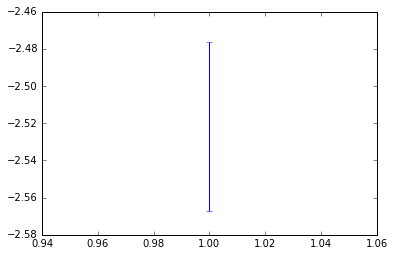

1000       Accept rate: 0.839
2000       Accept rate: 0.842
3000       Accept rate: 0.840
4000       Accept rate: 0.840
5000       Accept rate: 0.867
Energy = -2.5765 +- 0.0473, Auto correlation Time = 0.5453
Step 1, energy = -2.576458024627481


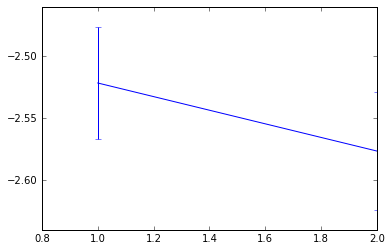

1000       Accept rate: 0.851
2000       Accept rate: 0.874
3000       Accept rate: 0.867
4000       Accept rate: 0.861
5000       Accept rate: 0.876
Energy = -2.5073 +- 0.0454, Auto correlation Time = 0.5330
Step 2, energy = -2.507331118605103


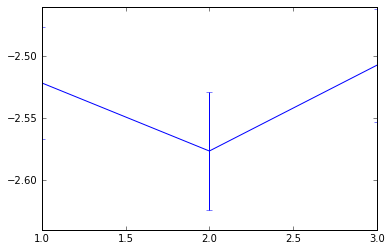

1000       Accept rate: 0.876
2000       Accept rate: 0.856
3000       Accept rate: 0.868
4000       Accept rate: 0.868
5000       Accept rate: 0.874
Energy = -2.6850 +- 0.0408, Auto correlation Time = 0.4268
Step 3, energy = -2.685037396178199


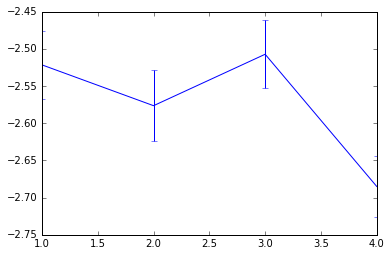

1000       Accept rate: 0.889
2000       Accept rate: 0.885
3000       Accept rate: 0.885
4000       Accept rate: 0.889
5000       Accept rate: 0.881
Energy = -2.4853 +- 0.0432, Auto correlation Time = 0.4725
Step 4, energy = -2.4852956303131912


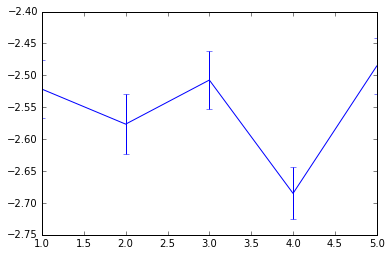

1000       Accept rate: 0.872
2000       Accept rate: 0.889
3000       Accept rate: 0.880
4000       Accept rate: 0.909
5000       Accept rate: 0.877
Energy = -2.5846 +- 0.0436, Auto correlation Time = 0.4833
Step 5, energy = -2.5846062786443182


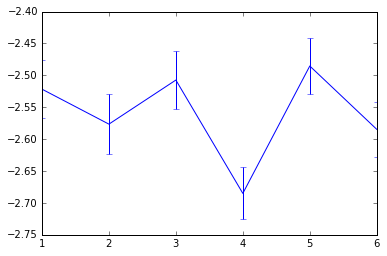

1000       Accept rate: 0.874
2000       Accept rate: 0.902
3000       Accept rate: 0.887
4000       Accept rate: 0.902
5000       Accept rate: 0.894
Energy = -2.5850 +- 0.0457, Auto correlation Time = 0.5193
Step 6, energy = -2.5849763763772104


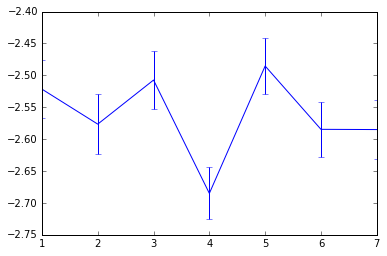

1000       Accept rate: 0.880
2000       Accept rate: 0.892
3000       Accept rate: 0.895
4000       Accept rate: 0.891
5000       Accept rate: 0.897
Energy = -2.6092 +- 0.0436, Auto correlation Time = 0.5032
Step 7, energy = -2.609156967009647


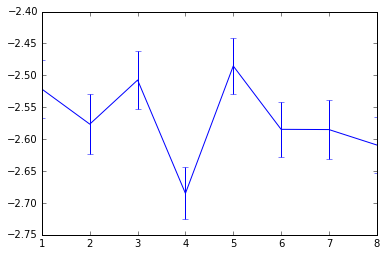

1000       Accept rate: 0.906
2000       Accept rate: 0.897
3000       Accept rate: 0.893
4000       Accept rate: 0.921
5000       Accept rate: 0.903
Energy = -2.6384 +- 0.0517, Auto correlation Time = 0.7254
Step 8, energy = -2.63837247971307


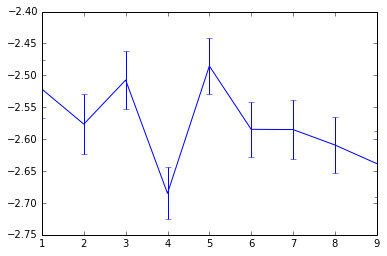

1000       Accept rate: 0.903
2000       Accept rate: 0.916
3000       Accept rate: 0.910
4000       Accept rate: 0.917
5000       Accept rate: 0.910
Energy = -2.5094 +- 0.0421, Auto correlation Time = 0.4855
Step 9, energy = -2.5094036377719577


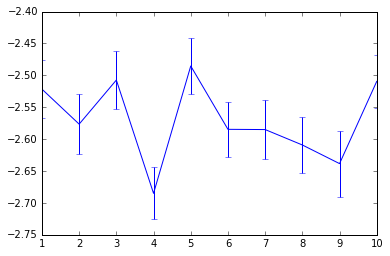

1000       Accept rate: 0.924
2000       Accept rate: 0.898
3000       Accept rate: 0.906
4000       Accept rate: 0.909
5000       Accept rate: 0.921
Energy = -2.6362 +- 0.0444, Auto correlation Time = 0.5148
Step 10, energy = -2.636166520274779


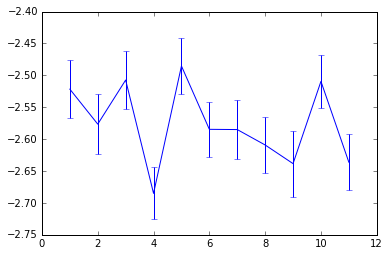

1000       Accept rate: 0.915
2000       Accept rate: 0.929
3000       Accept rate: 0.938
4000       Accept rate: 0.906
5000       Accept rate: 0.923
Energy = -2.5434 +- 0.0447, Auto correlation Time = 0.5177
Step 11, energy = -2.543397890680504


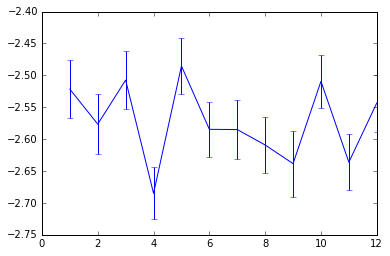

1000       Accept rate: 0.931
2000       Accept rate: 0.931
3000       Accept rate: 0.919


KeyboardInterrupt: 

In [36]:
run_demo()